# Lesson 4.4 随机梯度下降与小批量梯度下降

在上一小节中，我们谈到关于梯度下降算法的计算流程与算法特性，从中我们知道，梯度下降能够通过多轮迭代计算最终收敛至一个梯度为0的点。当损失函数为凸函数时，由于全域最小值点是唯一一个梯度为0的点，因此梯度下降能够顺利收敛至全域最小值，但如果损失函数不是凸函数，则梯度下降算法容易陷入局部最小值点陷阱或者鞍点陷阱。此时我们就需要考虑在原有算法基础之上对其进行“改良”。梯度下降算法的改善形式有很多种，其中最为简单有效的方式是调整每次带入训练的样本数量，通过局部规律规律的不一致性来规避“非全域最小值但梯度为0"的陷阱。当然在调整每次带入样本数量这一基本思路下，根据实际带入数据的多少也衍生出了两种算法一随机梯度下降和小批量梯度下降。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 画图模块
import matplotlib.pyplot as plt
import matplotlib as mpl

# 自定义模块
from ML_basic_function import *

## 一、损失函数理论基础

首先，我们需要补充部分关于损失函数的相关理论。

* 训练数据不同、损失函数和模型参数都不同

有一个简单但又经常容易被遗忘的事实，那就是带入训练的数据不同，损失函数会有所不同，进而训练出来的模型参数会有所不同，即最终得到不同的模型结果。例如有数据集如下：

![Alt text](image-60.png)

并且我们采用不带截距项的简单线性回归方程进行拟合：

$$
y = wx
$$

此时，损失函数计算公式为：

$$
\operatorname{MSELoss}(w)=\frac{\sum_{i=1}^n\left\|y_i-\hat{y}_i\right\|_2^2}{n}
$$

当我们带入全部四条数据进行计算时，损失函数为：

$$
\begin{aligned}
\operatorname{Loss}_4(w) & =\frac{(2-w)^2+(5-3 w)^2+(4-6 w)^2+(3-8 w)^2}{4} \\
& =\frac{110 w^2-100 w+54}{4}
\end{aligned}
$$

对应的，我们通过求解损失函数能够得到最优w结果，令损失函数导函数为0可得$w=\frac{100}{220}=\frac{5}{11}$，最终解得模型$y=\frac{5}{11} x$

而如果我们带入其中一条数据进行计算，例如带入第一条数据进行计算，则损失函数计算公式为：

$$\operatorname{Loss}_1(w)=(2-w)^2=w^2-4 w+4$$

此时解出最优参数结果为w=2，即训练得出模型为y=2x。很明显，带入训练数据不同、损失函数不同、训练所得模型也不同。

* 损失函数其实是数据集规律的一种表现

由于模型其实是数据集规律的体现，而损失函数交是求解模型参数的基本函数，因此我们可以认定损失函数其实是一批数据所表现出规律的一种体现，并且不同数据的损失函数不同，我们就认定这几批数据对应的基本规律有所不同。如上述两个损失函数形态不同，其实也就代表着其背后的数据基本规律各不相同。

* 规律一致，损失函数也一致

但是，我们同时需要知道的是，有时数据看似不同，但实际上背后规律一致，此时损失函数其实也是一致的。从原理上讲，损失函数是指导求解全域最小值的方程，而如果多条（部分）数据规律一致，则构建出来的损失函数也将基本一致，至少是全域最小值点将保持一致，例如下述两条数据规律一致，都满足y=2x这一基本规律。

![Alt text](image-61.png)

则围绕这两条数据分别构造损失函数，可得出如下结果：

$$
\begin{gathered}
\operatorname{MSELoss}(w)_1=(2-w)^2 \\
\operatorname{MSELoss}(w)_2=(4-2 w)^2=4(2-w)^2
\end{gathered}
$$

而这两个损失函数，尽管看起来系数差距成一定比例，但这种差异其实并不影响实际梯度下降的计算过程，上述$MSELOSS_{1}$和$MSELOSS_{2}$ 的比例完全可以通过在迭代过程中设置负比例的学习率来确保最终参数迭代过程完全一致，例如我们可以令初始w取值为0，则两个损失函数的迭代过程如下：

不难发现，二者完全一致。也就是说损失函数的等比例差异其实完全可以通过学习率消除，而学习率又是人工设置的参数。因此从这个意义上来说，相同规律不同数据所创造的损失函数本质上还是“相同"的损失函数。当然，如果此时我们再构建一个由这两条数据共同构建的损失函数，则该损失函数和上述两个损失函数也是一致的。

> 值得注意的是，损失函数的该特性也将是影响随机梯度下降或者小批量梯度下降有效性的根本因素。

至此，我们再反观第一小节中的$Loss(w)_{4}$和$Loss(w)_{1}$,二者之所以会表现出差异，是因为$Loss(w)_{4}$背后的四条数据所表现出的整体规律和$MSELoss(w)_{1}$后背的一条数据所表现出的规律不一致。

![Alt text](image-62.png)

$$
\operatorname{Loss}_4(w)=\frac{110 w^2-100 w+54}{4}
$$

![Alt text](image-63.png)

$$
\operatorname{Loss}_1(w)=(2-w)^2=w^2-4 w+4
$$

* 局部规律与整体规律

为了方便区分，我们将训练数据集所表现出来的规律称为训练数据的整体规律，而单独某条或者某几条数据所表现出来的规律称为局部规律。对于数据集1来说，第一条数据所表现出的局部规律和整个数据集所表现出来的规律并不一致，而对于数据集2来说，第一条数据、第二条数据和整个数据集表现出来的规律都一致。另外，我们也将训练数据集中的一部分数据称为训练数据的子数据集。

不过，在大多数实际获取到的数据中，由于存在各方面误差，很难出现类似数据集2的这种多条数据规律完全一致的情况，在大多数情况下训练数据集的子数据集往往都存在一定的规律差异，不仅是不同的子数据集之间存在差异，而且子数据集和训练数据集整体之间也存在一定的规律差异。

* 局部规律和整体规律的相对统一

尽管局部规律和整体规律并不一致，但局部规律和整体规律却是相对统一的。例如，我们还是以数据集1为例，并且以前两条数据构造第一个损失函数Loss2、后两条数据构造另一个损失函数Loss3,则有损失函数计算公式如下：

![Alt text](image-64.png)

$$
\begin{aligned}
\text { Loss }_2 & =\frac{(2-1 w)^2+(5-3 w)^2}{2} \\
& =\frac{w^2-4 w+4+9 w^2-30 w+25}{2} \\
& =\frac{10 w^2-34 w+29}{2}
\end{aligned}
$$

$$
\begin{aligned}
\text { Loss }_3 & =\frac{(4-6 w)^2+(3-8 w)^2}{2} \\
& =\frac{36 w^2-48 w+16+64 w^2-48 w+9}{2} \\
& =\frac{100 w^2-96 w+25}{2}
\end{aligned}
$$

而此时，整体损失函数其实就是上述二者的平均值：

$$
\operatorname{Loss}_4(w)=\frac{110 w^2-100 w+54}{4}
$$

因此我们可以将其理解为：代表局部规律的损失函数其实也能够部分表示整体损失函数。

> 一种更加严谨的表述是，局部规律的损失函数平均来说是整体损失函数的一个良好的估计。

当然，局部规律彼此之间也是相对统一的。

* 梯度下降计算过程改善思路

据此，我们即可进一步讨论关于梯度下降的改善思路。

简单来说就是，梯度下降过程中每一次参数移动都是基于整体规律（全部数据集对应的损失函数）来进行每一次参数迭代，而无论是随机梯度下降(Stochastic Gradient Descent)还是小批量梯度下降(Mini-batch Gradient Descent),其实都是在利用局部规律（部分数据的损失函数）来进行每一次参数迭代，其中随机梯度下降每次参数迭代都挑选一条数据来构建损失函数，而小批量梯度下降则每次选择一个小批数据（训练数据集的子集）来进行迭代，例如总共100条数据等分成10个子集，每个子集包含0条数据，然后每次梯度下降带入其中一个子集的损失函数进行计算。按照这种划分方法，原始梯度下降算法也被称为BGD(Batch Gradient Descent,批量梯度下降)。当然不难发现，SGD和BGD其实都是小批量梯度下降的特例，即在小批量梯度下降中，当子集等于全集时，小批量梯度下降就是BGD,而当每个子集只有一条数据时，小批量梯度下降就是SGD。

> 值得注意的是，在某些深度学习计算框架(如PyTorch)，小批量梯度下降也被划入SGD范畴。

这种修改思路本身其实不难理解，但如何通过这种方法来优化梯度下降过程，并使得其能够跳出局部最小值点呢？在这个过程中局部规律的不一致性又是如何发挥作用的？这就需要我们深入随机梯度下降和小批量梯度下降的具体计算流程当中来进行观察。

简单总结上述理论基础：

* 数据规律可以用损失函数表示，损失函数形态不同代表其背后构造损失函数的数据规律不同；
* 一般来说，对于一个数据集来说，局部规律之间和局部规律与整体规律之间就存在一定的差异，但也存在一定的统一性；
* 利用局部规律之间的“对立统一“的特性，我们就能够在参数移动过程中改变参数移动方向，从而避免局部最小值或者鞍点陷
阱。

## 二、随机梯度下降(Stochastic Gradient Descent)

### 1. 随机梯度下降计算流程

首先我们来讨论关于SGD的计算流程及使用过程中的注意事项。还是先从一个简单的例子入手，假设现有数据集如下：

![Alt text](image-65.png)

此时如果我们采用SGD进行参数点的更新迭代，则每次提取一条数据构造损失函数然后再进行计算，同样我们构建不带截距项的简单线性回归$y=wx$进行建模，则第一条数据的损失函数为：

$$
\operatorname{Loss}_1(w)=(2-w)^2
$$

第二条数据的损失函数为

$$
\operatorname{Loss}_2(w)=(5-3 w)^2
$$

实际SGD执行过程中，首先我们会将数据集乱序处理，然后依次挑选每一条数据的损失函数进行参数更新计算。当然如果是进行了训练集和测诚集的随机切分，则无需再次进行乱序处理，现假设上述数据就是乱序处理之后的结果，在给定初始参数$w_{0} = 0$的情况下，我们可以根据如下过程进行参数迭代，首先进行参数和数据的定义

In [2]:
w = 0

In [3]:
x = np.array([[1], [3]])
x

array([[1],
       [3]])

In [4]:
y = np.array([[2], [5]])
y

array([[2],
       [5]])

然后即可开始第一轮迭代，带入第一条数据进行参数的第一次修改，实际计算过程等价于借助第一条数据的损失函数所计算出的梯度进行参数的修改，过程如下：

In [5]:

# 执行第一轮迭代
w = w_cal(x[0], w, y[0], gd_cal= lr_gd, lr = 0.02, itera_times = 1)
w

0.08

紧接着，利用第二条数据的损失函数梯度进行参数的第二次修改

In [6]:
# 执行第二轮迭代
w = w_cal(x[1], w, y[1], gd_cal= lr_gd, lr = 0.02, itera_times = 1)
w

0.6512

对比梯度下降计算过程

In [7]:
w = 0
w = w_cal(x, w, y, gd_cal= lr_gd, lr = 0.02, itera_times = 2)
w

array([[0.612]])

至此，我们总共执行了两轮迭代，参数也就移动了两步。而全部数据只有两条，两轮迭代正好用了一轮全部数据，此时我们称为迭代了一轮epoch，即梯度下降过程遍历了一遍数据。在随机梯度下降和小批量梯度下降过程中，一般我们采用epoch指标去来说明目前迭代进度。接下来我们尝试迭代40个epoch。

In [8]:
w = 0
epoch = 40
for j in range(epoch):
    for i in range(2):
        w = w_cal(x[i], w, y[i], gd_cal= lr_gd, lr = 0.02, itera_times = 1)

In [9]:
w

1.6887966746685015

当然，我们也可将上述过程定义为一个函数：

In [10]:
def sgd_cal(X, w, y, gd_cal, epoch, lr = 0.02):
    """随机梯度下降计算函数
    :param X: 训练数据
    :param w: 权重
    :param y: 标签
    :param gd_cal: 梯度计算函数
    :param epoch: 迭代次数
    :param lr: 学习率
    :return: 权重
    """
    m = X.shape[0]
    n = X.shape[1]
    for j in range(epoch):
        for i in range(m):
            w = w_cal(X[i].reshape(1, n), w, y[i].reshape(1, 1), gd_cal= gd_cal, lr = lr, itera_times = 1)
    return w

验证函数输出结果

In [11]:
w = 0
sgd_cal(x, w, y, gd_cal= lr_gd, epoch = 40, lr = 0.02)

array([[1.68879667]])

那么，1.688是否是全域最小值点呢？此时我们也可以对比梯度下降围绕上述问题计算所得结果：

In [12]:
# 梯度下降计算过程
w = 0
w = w_cal(x, w, y, gd_cal= lr_gd, lr = 0.02, itera_times = 100)
w

array([[1.7]])

而整体损失函数为：

$$
\operatorname{Loss}(w)=w^2-4 w+4+9 w^2-30 w+25=10 w^2-34 w+29
$$

对应梯度计算公式为

$$
\nabla_w \operatorname{Loss}(w)=20 w-34
$$

因此，全域最小值点为

$$
w=\frac{34}{20}=1.7
$$

也就是说明，随机梯度下降尽管有效，但其实无法像批量梯度下降一样收敛至全域最优解，随机梯度下降只能收敛到全域最小值点附近。要弄清楚这背后的原因以及找出优化的方法，我们需要进一步探究随机梯度下降的算法特性。

### 2. 随机梯度下降的算法特性

尽管从执行流程上来看，SGD只是将梯度下降的"每次带入全部数据进行计算"改成了“每次带入一条数据进行计算”，但实际上，这么做会极大程度影响参数每一次移动的方向，从而使得参数最终无法收敛至全域最优解，但同时这么一来却也使得参数迭代过程能够跨越局部最小值点。

还是回顾上述例子中参数的迭代过程，在第一轮epoch的第一次迭代时，参数点从0出发，实际上是根据第一条数据的损失函数最小值点前进的。第一条数据的损失函数及图像如下：

$$
\operatorname{Loss}_1(w)=(2-w)^2
$$

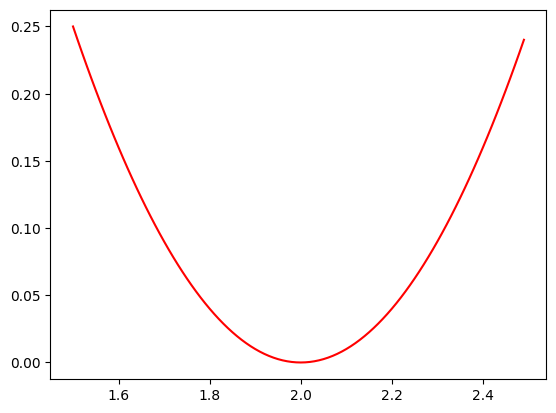

In [13]:
x1 = np.arange(1.5, 2.5, 0.01)
y1 = np.power(2-x1, 2)
plt.plot(x1, y1, color = 'red')

也就是朝向w=2这个点前进的。而第二次迭代时，参数点则是朝向第二条数据对应的损失函数最小值方向前进的。第二条数据的损失函数及图像如下所示：

$$
\operatorname{Loss}_2(w)=(5-3 w)^2
$$

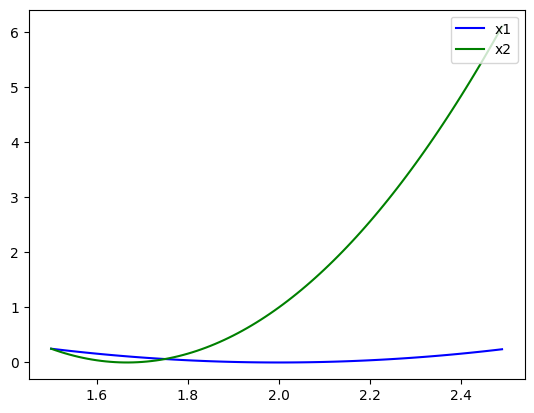

In [14]:
y2 = np.power(5-3*x1, 2)
plt.plot(x1, y1, color = 'blue', label = 'x1')
plt.plot(x1, y2, color = 'green', label = 'x2')
plt.legend(loc = 'upper right')

第二条数据损失函数的极小值点为1.667,两条数据的损失函数极小值点并不一致，并且全域最小值点就位于1.667和2之间。因此，在实际迭代过程中，当参数点位于两个极小值点左侧时，及参数小于1.667时候，无论是遵照哪一条数据的损失函数进行梯度下降，都能朝向全域最小值点前进。但当参数点迭代至1.667和2之间时，这时参数的迭代就会陷入"进退两难"的境地，当带入第二条数据进行梯度下降时，算法执行过程会要求参数点往后退，退到1.667这个点；而如果带入第一条数据进行梯度下降时，算法执行过程会要求参数点往前走，走到2这个点。我们可以详细参数点移动过程观察。

> 不同的损失函数“要求”不同的迭代方向。

In [15]:
w = 0
epoch = 40

In [16]:
for j in range(epoch):
    for i in range(2):
        w = w_cal(x[i], w, y[i], gd_cal= lr_gd, lr = 0.02, itera_times = 1)
        print(w)

0.08
0.6512
0.705152
1.05129728
1.0892453888
1.297117048832
1.32523236687872
1.4481487148023808
1.4702227662102856
1.540942570374583
1.5593048675595995
1.5979551152381437
1.6140369106286179
1.6329836228023156
1.6476642778902229
1.6545051378497426
1.668324932335753
1.667727956694882
1.6810188384270868
1.6758520565933355
1.6888179743296021
1.6808435035709453
1.6936097634281075
1.6839102485939887
1.6965538386502292
1.6857944567361467
1.6983626784667007
1.6869521142186885
1.6994740296499409
1.687663378975962
1.7001568438169237
1.6881003800428311
1.7005763648411178
1.6883688734983155
1.7008341185583828
1.688533835877365
1.7009924824422704
1.688635188763053
1.701089781212531
1.6886974599760198
1.701149561576979
1.6887357194092665
1.7011862906328958
1.6887592260050532
1.7012088569648511
1.6887736684575048
1.7012227217192046
1.688782541900291
1.7012312402242795
1.6887879937435388
1.7012364739937973
1.6887913433560302
1.701239689621789
1.6887934013579449
1.701241665303627
1.6887946657943214
1.7

* 结果震荡与逃离局部最小值点

我们发现，最终参数是在1.7和1.68这两个点之间来回震荡，也就是陷入了“进退两难"的境地。在考虑如何改善这个问题之前，我们先来看下这种参数点在迭代过程中方向不定带来的影响。从上述的迭代过程我们发现，参数方向出现不一致的情况出现在当参数位于两个极小值点之间时，而并不受到全域最小值点1.7的影响，或者说并“不受到整体损失函数梯度为0的点影响。那么我们合理推测，就将有可能出现一种情况，那就是整体损失函数存在局部最小值，但某条数据在该点的梯度不为0。那么，当参数迭代至全域局部最小值点时正好带入该条数据进行梯度下降，由于该条数据在该点梯度不为0，因此参数就将顺利跨过局部最小值点。假设现在全部训练数据的损失函数为$y=x \cdot \cos (\pi x)$,而某条数据的损失函数为$y=(x-0.7)^2$，则当参数在0.35附近时，带入该条数据进行梯度下降时就能顺利跨过0.35局部最小值点。

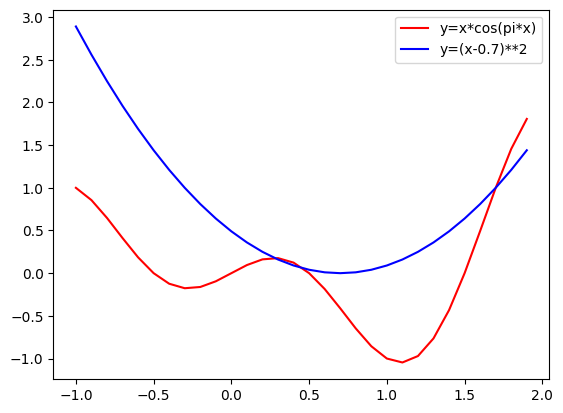

In [17]:
x1 = np.arange(-1, 2, 0.1)
y1 = x1 * np.cos(np.pi * x1)
y2 = np.power(x1 - 0.7, 2)
plt.plot(x1, y1, color = 'red', label = 'y=x*cos(pi*x)')
plt.plot(x1, y2, color = 'blue', label = 'y=(x-0.7)**2')
plt.legend(loc = 'upper right')

而这种帮助跨越局部最小值点或者鞍点的优秀性质，使得随机梯度下降成为比梯度下降应用更广的优化算法。当然要做到这点，最为核心的一点是局部数据的损失函数和全部数据的损失函数不一致，及局部规律和全局规律不一致。也就是说本质上来看我们是利用这种不同数据之间规律的差异性来帮助参数点逃脱局部最小值陷阱。

总结上述过程：SGD的计算本质是借助局部规律（而不是整体规律）来更新参数，而局部规律不一致性能够让参数在移动过程中保持灵活的移动方向，并因此能够逃离局部最小值点或鞍点陷阱，但方向不一致的代价是最终无法收敛到一个稳定的点，要改进这一问题则需要借助额外优化手段。

> 当然，小批量梯度下降也有该性质。并且在机器学习领域，很多时候我们都会借助局部规律不一致性来拓展算法性能，例如集成算法中的随机森林。

* 震荡迭代与损失函数波动

当然，这种参数迭代方向的不确定性的另一方面影响，就是容易会造成整体损失函数在收敛过程不断波动。其实这并不难理解，只要参数的行进方向不是和全部数据的损失函数的梯度递减方向保持一致，只要参数在中途发生方向的调整，就会导致由全部数据构造的损失函数计算结果的震荡。例如在上述例子迭代过程中，我们可以观察整体MSE变化情况。

In [18]:
w = 1.5
MSE_l = [MSE(x, w, y)]
for j in range(20):
    for i in range(2):
        w = w_cal(x[i], w, y[i], gd_cal= lr_gd, lr = 0.02, itera_times = 1)
        MSE_l.append(MSE(x, w, y))

In [19]:
MSE_l

[0.25,
 0.21199999999999977,
 0.13089920000000005,
 0.11062326272000009,
 0.08400789001011207,
 0.07256093389731925,
 0.06511983054738196,
 0.05831951869034879,
 0.057260421826522606,
 0.05302136766320569,
 0.053845447933804295,
 0.051069184906397024,
 0.05228099727967431,
 0.05036163031661431,
 0.05152126731453872,
 0.05011258216169952,
 0.05113054104247488,
 0.050029656331263814,
 0.05091918742111352,
 0.05000516454698343,
 0.05080016888984587,
 0.05000010429713661,
 0.05073113478522416,
 0.0500007654355502,
 0.05069026448720927,
 0.05000259482519651,
 0.050665736713178436,
 0.050004256036998436,
 0.050650886900189325,
 0.050005479484877116,
 0.05064184624170157,
 0.05000630772544407,
 0.05063632301772303,
 0.05000684549468766,
 0.050632941385629446,
 0.05000718680883091,
 0.05063086817908283,
 0.050007400630144506,
 0.050629596087674075,
 0.05000753355641621,
 0.050628815151418]

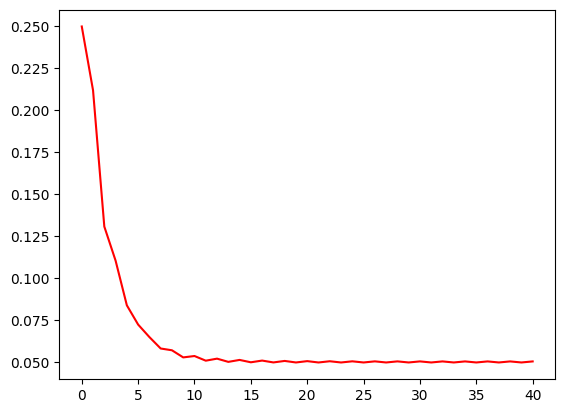

In [20]:
plt.plot(list(np.arange(41)), np.array(MSE_l).flatten(), color = 'red', label = 'MSE')

* 等高线图观察SGD迭代过程

当然上述例子损失函数波动并不明显，但在很多复杂模型运算过程中，受到每次迭代的方向不一致的影响，损失函数还是会受到较大影响。当然，这种影响我们还可以通过观察参数点逼近全域最小值点过程中的进行路径来体会，例如我们借助Lesson4.3中定义的数据及轨迹绘制函数来进行简单实验。

![Alt text](image-66.png)

In [21]:
np.random.seed(24)
w = np.random.randn(2, 1)
w

array([[ 1.32921217],
       [-0.77003345]])

In [22]:
features = np.array([1, 3]).reshape(-1, 1)
features = np.concatenate((features, np.ones_like(features)), axis = 1)
features

array([[1, 1],
       [3, 1]])

In [23]:
labels = np.array([2, 4]).reshape(-1, 1)
labels

array([[2],
       [4]])

In [24]:
# 随机梯度下降参数点运行轨迹
w_res = [np.copy(w)]

In [25]:
for i in range(40):
    w_res.append(np.copy(sgd_cal(features, w_res[-1], labels, gd_cal= lr_gd, epoch = 1, lr = 0.1)))

In [26]:
w_res[-1]

array([[1.00686032],
       [0.96947505]])

In [27]:
np.random.seed(24)
w1 = np.random.randn(2, 1)
w1

array([[ 1.32921217],
       [-0.77003345]])

In [28]:
# 梯度下降参数点运行轨迹
w1, w_res_1 = w_cal_rec(features, w1, labels, gd_cal= lr_gd, lr = 0.1, itera_times = 100)

In [29]:
w_res_1[-1]

array([[1.02052278],
       [0.95045363]])

In [30]:
# 网格点坐标
x1, x2 = np.meshgrid(np.arange(1, 2, 0.001), np.arange(-1, 1, 0.001))

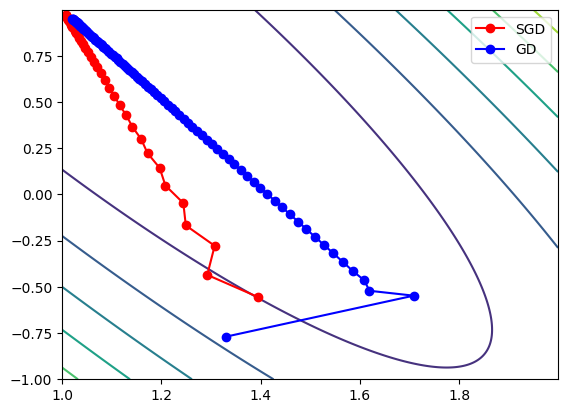

In [31]:
# 绘制等高线图
plt.contour(x1, x2, (2 - x1 - x2)**2 + (4 - 3*x1 - x2)**2)

# 绘制参数点移动轨迹
plt.plot(np.array(w_res)[:, 0], np.array(w_res)[:, 1], '-o',color = 'red', label = 'SGD')
plt.plot(np.array(w_res_1)[:, 0], np.array(w_res_1)[:, 1],  '-o',color = 'blue', label = 'GD')
plt.legend(loc = 'upper right')

能够看出，在参数迭代过程中，随机梯度下降的方向不一致将对迭代过程造成较大影响。正所谓"成于斯者毁于斯”，我们借助随机性去帮助算法跨越局部最小值陷阱，但却引出了其他的麻烦一关于如何解决这些"麻烦”，就是我们后续要讨论的围绕随机梯度下降算法的优化算法。

### 3.随机梯度下降求解线性回归

接下来，我们尝试使用随机梯度下降求解线性回归问题。

* Step1.确定数据集和模型

仍然还是创建扰动项不大、基本满足$y=2x_{1}-x_{2}+1$规律的数据集。

In [32]:
# 设置随机数种子
np.random.seed(24)

# 扰动项取值为0.01
features, labels = arrayGenReg(delta=0.01)


* Step2.设置初始参数

In [33]:
np.random.seed(24)
w = np.random.randn(3, 1)
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

In [34]:
# 计算w取值时SSE
SSELoss(features, w, labels)

array([[2093.52940481]])

In [35]:
# 计算w取值时MSE
MSE(features, w, labels)

2.093529404807162

* Step3 执行梯度下降计算

接下来，借助此前所定义的参数更新函数进行梯度下降参数求解：

In [36]:
w = sgd_cal(features, w, labels, lr_gd, epoch= 40, lr= 0.02)
w

array([[ 1.99749114],
       [-0.99773197],
       [ 0.99780476]])

In [37]:
# 计算w取值时的SSE
SSELoss(features, w, labels)

array([[0.1048047]])

In [38]:
# 计算w取值时MSE
MSE(features, w, labels)

0.00010480470014328864

至此，我们就完成了随机梯度下降求解损失函数的完整流程。

### 4.随机梯度下降算法评价

根据上述讨论和实现，我们基本掌握了随机梯度下降求解损失函数的基本思路与实现方法，相比梯度下降，随机梯度下降由于引入了一定的随机性，借助局部规律不一致性来跳出局部最小值点陷阱，可以说是一项重大进步。而由于在大多数复杂模型中损失函数都不一定是严格意义凸函数，因此随机梯度下降也有着比梯度下降更广泛的应用场景。

不过，值得一提的是，随机梯度下降的计算过程还是“过于“随机了，在很多复杂模型中，这种随机性所造成的迭代收敛上的麻烦几乎和这种随机性所带来的益处不相上下，比如迭代需要更多次数、最终收敛结果不稳定等等，要对其进行改善，我们能够想到的一个最为基础的办法就是在确保一定程度随机性的基础上增加一些算法的稳定性。即尝试适度修正每次迭代所带入的样本量，也就是合理设置每次迭代参数所带入的数据量，一方面我们还是希望借助局部规律的不确定性来规避局部最小值陷阱，同时我们也希望一定程度控制住迭代过程随机性，来减少随机性所带来的麻烦。而这种每次迭代过程带入若干条样本的梯度下降算法，就被称为小批量梯度下降。

> 当然，如果每条数据都和整体数据的规律基本一致，例如(1,2)、(2,4)这种数据集，那么其实随机梯度下降收敛效率会更高，毕竟计算一条数据就相当于计算了一个数据集。但此时因为不同数据彼此之间并不存在局部规律的不一致性，所以随机梯度下降也无法帮助跳过局部最小值点。

## 三、小批量梯度下降

所谓小批量梯度下降，其实就是对随机梯度下降过程稍作修改一每次不在是带入一条数据进行计算，而是带入batch_size条数据进行计算，当然batch_size是一个人工设置的超参数。通过这么一个微小的变化，算法在实际性能上将发生根本性变化。而小批量梯度下降，目前也是梯度下降算法家族中最为通用的算法。

> 更多关于梯度下降、随机梯度下降及小批量梯度下降的算法性能比较及算法优化，详见Lesson4.4。

### 1.小批量梯度下降计算流程

还是一样，我们先通过简单的一个实例来观察小批量梯度下降的计算流程。还是以开篇数据集为例：

![Alt text](image-67.png)

当我们在执行小批量梯度下降时，我们会先将训练数据进行"小批量"的切分，例如我们可以将上述数据集切分成两个mini-batch,前两条数据为第一批，后两条数据为第二批。然后按照类似随机梯度下降的计算过程来进行计算。

* 数据切分

In [39]:
x = np.array([1, 3, 6, 8]).reshape(-1, 1)
x

array([[1],
       [3],
       [6],
       [8]])

In [40]:
y = np.array([2, 5, 4, 3]).reshape(-1, 1)

In [41]:
x1 = x[:2]
x2 = x[2:]
y1 = y[:2]
y2 = y[2:]

* 第一轮(epoch)迭代

在数据集切分完成后，接下来我们开始进行参数更新。和随机梯度下降一样，当我们遍历一次数据集之后，就称为一轮epoch迭代完成。此时我们将数据集划分为两批，两批依次带入训练完之后就相当于第一轮epoch迭代完成。

In [42]:
w = 0
w = w_cal(x1, w, y1, gd_cal= lr_gd, lr = 0.02, itera_times = 1)
w = w_cal(x2, w, y2, gd_cal= lr_gd, lr = 0.02, itera_times = 1)
w 

array([[0.62]])

* 多轮(epoch)迭代

当然，如果希望针对更为一般的数据集进行可手动调节batch_size的小批量梯度下降计算，我们可以将上述sgd_cal进行修改，将小批量梯度下降和随机梯度下降整合至一个函数中。具体计算函数如下：

In [43]:
def sgd_cal(X, w, y, gd_cal, epoch, batch_size=1, lr=0.02, shuffle=True, random_state=24):
    """随机梯度下降和小批量梯度下降计算函数
    :param X: 训练数据
    :param w: 权重
    :param y: 标签
    :param gd_cal: 梯度计算函数 
    :param epoch: 迭代次数
    :param batch_size: 批量大小
    :param lr: 学习率
    :param shuffle: 是否打乱数据
    :param random_state: 随机数种子
    """
    m = X.shape[0]
    n = X.shape[1]
    batch_num = np.ceil(m / batch_size)
    X = np.copy(X)
    y = np.copy(y)
    for j in range(epoch):
        if shuffle:
            np.random.seed(random_state)
            np.random.shuffle(X)
            np.random.seed(random_state)
            np.random.shuffle(y)
        for i in range(np.int64(batch_num)):
            w = w_cal(X[i * batch_size: np.min([(i+1)*batch_size, m])], w, 
                      y[i * batch_size: np.min([(i+1)*batch_size, m])], 
                      gd_cal= gd_cal, lr = lr, itera_times = 1)
    return w

此处需要注意，首先是借助np.ceil函数计算切分成几批。这里需要注意，如果最后一批剩余数据不足batch_size数量，则也可以将其化为一批。例如以x为例，每三条数据分为一批时，总共可以分成两批

In [44]:
np.ceil(4/3)

2.0

In [45]:
for i in range(2):
    print(x[i*3 : np.min([(i+1)*3, 4])])

[[1]
 [3]
 [6]]
[[8]]


函数测试：

In [65]:
# 初始参数为0，两条数据为1批，迭代10轮epoch 
w = 0
sgd_cal(x, w, y, gd_cal= lr_gd, epoch= 10, batch_size=2, lr= 0.03, shuffle=True, random_state=24)

array([[0.72299119]])

In [66]:
# 对比梯度下降计算过程
w = 0
w_cal(x, w, y, gd_cal= lr_gd, lr = 0.03, itera_times = 10)

array([[0.58295383]])

并且，如果将每一批数据的数据量设置为样本总数时，计算过程就相当于梯度下降

In [48]:
# 初始参数为0，两条数据为1批，迭代10轮epoch 
w = 0
sgd_cal(x, w, y, gd_cal= lr_gd, epoch= 10, batch_size=4, lr= 0.02)

array([[0.59090909]])

当然，如果将每一批数据的数据量设置为1，其计算过程就相当于随机梯度下降

In [49]:
w = 0
for j in range(10):
    for i in range(4):
        w = w_cal(x[i], w, y[i], gd_cal= lr_gd, lr = 0.002, itera_times = 1)
w

0.5379624189411458

In [50]:
w = 0
w = sgd_cal(x, w, y, lr_gd, epoch= 10, batch_size=1, lr= 0.002, shuffle=False, random_state=24)
w

array([[0.53796242]])

### 2. 小批量梯度下降算法特性

尽管小批量梯度下降每次带入了更多的数据进行参数训练，但其算法特性和随机梯度下降还是比较类似的，在训练阶段，每次训练实际上是利用某批数据的综合规律（综合损失函数）来进行参数训练，同时，小批量梯度下降也是借助不同批次数据的规律不一致性帮助参数跳出局部最小值陷阱，并且，由于规律不一致性，小批量梯度下降最终收敛结果也会呈现小幅震荡，只不过在所有的“随机不确定性“的方面，小批量梯度下降都比随机梯度下降显得更加稳健。当然，在必要时，我们也会将小批量梯度下降转化为梯度下降或者随机梯度下降。更多的算法选择和优化理论我们将在下一小节进行详细讨论。

### 3.小批量梯度下降求解线性回归

最后，我们尝试使用小批量梯度下降求解线性回归问题，我们将采用更加正式的流程来进行计算。

首先，我们仍然还是创建扰动项不大、基本满足y=2x1 - x2+1规律的数据集。

In [51]:
# 设置随机数种子
np.random.seed(24)

# 扰动项取值为0.01
features, labels = arrayGenReg(delta=0.01)


然后进行数据集切分

In [52]:
Xtrain, Xtest, ytrain, ytest = array_split(features, labels, rate=0.7, random_state=24)

In [53]:
Xtrain.shape

(700, 3)

接下来进行初始参数的设置

In [54]:
np.random.seed(24)
w = np.random.randn(3, 1)
w

array([[ 1.32921217],
       [-0.77003345],
       [-0.31628036]])

然后借助小批量梯度下降进行参数求解

In [55]:
w = sgd_cal(Xtrain, w, ytrain, lr_gd, epoch= 40, batch_size=100, lr= 0.02, shuffle=True, random_state=24)
w

array([[ 1.99974065],
       [-0.99985936],
       [ 0.99932142]])

计算训练误差和测试误差

In [56]:
# 训练误差
MSE(Xtrain, w, ytrain)

9.416288918435462e-05

In [57]:
# 测试误差
MSE(Xtest, w, ytest)

9.087240255400126e-05

对于求解数值解的算法来说，观察其迭代过程是进行后续优化的第一步，因此我们可以编写如下过程来观察伴随迭代进行，模型训练误差和测试误差如何变化。

In [58]:
np.random.seed(24)
w = np.random.randn(3, 1)

train_loss = []
test_loss = []

epoch = 20

In [59]:
for i in range(epoch):
    w = sgd_cal(Xtrain, w, ytrain, lr_gd, epoch= 1, batch_size=100, lr= 0.02, shuffle=True, random_state=24)
    train_loss.append(MSE(Xtrain, w, ytrain))
    test_loss.append(MSE(Xtest, w, ytest))
    

Text(0, 0.5, 'MSE')

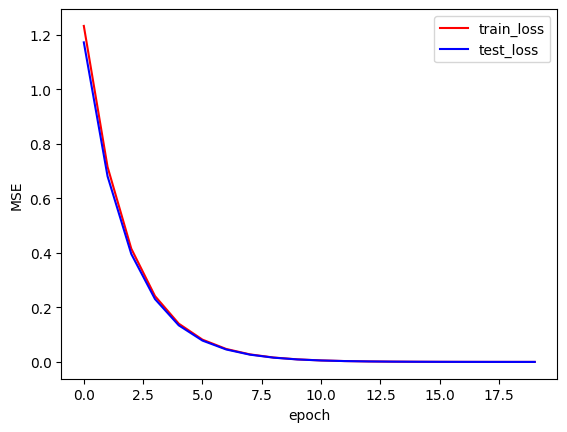

In [60]:
plt.plot(np.arange(epoch), train_loss, color = 'red', label = 'train_loss')
plt.plot(np.arange(epoch), test_loss, color = 'blue', label = 'test_loss')
plt.legend(loc = 'upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')